In [2]:
import os
import pandas as pd
from glob import glob
import numpy as np
import matplotlib as plt
from matplotlib.image import imread
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


# Load Dataset

In [7]:
image_shape  = (56,64,1)
train_path = "data/Eye gaze/train/"
test_path  = "data/Eye gaze/test/"

In [3]:
os.listdir(train_path)

['center', 'left', 'right']

In [8]:
img=imread(train_path+'left/'+'68.jpg')

In [9]:
folders=glob(test_path + '/*')

# Data Augmentation

In [10]:
traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1/255.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode='nearest'
                              )

testdata_gen=ImageDataGenerator(

                             rescale=1./255)

In [11]:
traindata_gen.flow_from_directory(train_path)

Found 3622 images belonging to 3 classes.


# Build Model

In [12]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same',input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(len(folders)))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 8, 128)         0

# Train

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [15]:
batch_size = 32
traning_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical')

Found 3622 images belonging to 3 classes.


In [16]:
testing_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 color_mode="grayscale",
                                                 class_mode = 'categorical',
                                            shuffle=False)

Found 831 images belonging to 3 classes.


In [17]:
testing_set.class_indices

{'center': 0, 'left': 1, 'right': 2}

In [18]:
result = model.fit(
  traning_set,
  epochs=8,
  validation_data=testing_set,
  callbacks=[early_stop]

)

Epoch 1/8
114/114 [==============================] - 49s 411ms/step - loss: 0.3153 - accuracy: 0.8774 - val_loss: 0.0194 - val_accuracy: 0.9916
Epoch 2/8
114/114 [==============================] - 15s 127ms/step - loss: 0.0466 - accuracy: 0.9854 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 3/8
114/114 [==============================] - 17s 148ms/step - loss: 0.0278 - accuracy: 0.9901 - val_loss: 8.9359e-04 - val_accuracy: 1.0000
Epoch 4/8
114/114 [==============================] - 15s 130ms/step - loss: 0.0245 - accuracy: 0.9909 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/8
114/114 [==============================] - 15s 130ms/step - loss: 0.0227 - accuracy: 0.9939 - val_loss: 0.0012 - val_accuracy: 1.0000


In [19]:
losses = pd.DataFrame(model.history.history)

<Axes: >

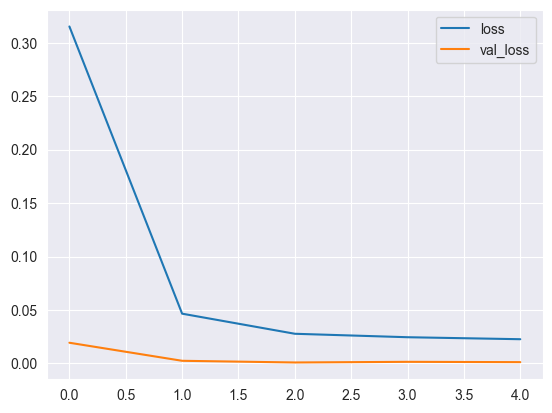

In [20]:
losses[['loss','val_loss']].plot()

In [21]:
model.save('models/gazev3.1.h5')

C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
